# Pull data and extract ingredients

This notebook will pull ingredients data from nourish and extract only the ingredients while attempting to remove other text.

At the time of writing this code, the data is pulled from FoodData Central for Oct 2022, which is an upgrade to the 2018 Branded Foods product database: https://fdc.nal.usda.gov/download-datasets.html

This specific data is from the food_nutrient table.

__Note:__ At the time of this writing, all ingredients were stored as an unformatted list which would be seen on a food label.



Field descriptions (https://fdc.nal.usda.gov/portal-data/external/dataDictionary)
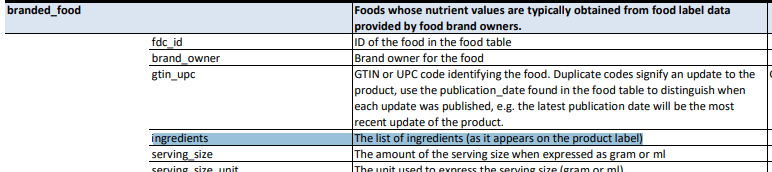


## Connect to the postgresql server and pull data

In [2]:
import pandas as pd
import numpy as np
import sqlalchemy as sal

from nltk.tokenize import word_tokenize
from sqlalchemy import text

In [13]:
ingredients_extracted_csv_p = r"../../data/ingredients_extracted.csv.gz"

#### Connect to the nourish database

In [4]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [5]:
nourish_user = "gmichael"

nourish_pswd = "567khcwx3s"

engine = sal.create_engine('postgresql+psycopg2://' + nourish_user + ':' + nourish_pswd + '@awesome-hw.sdsc.edu/nourish')
conn = engine.connect()

#### Pull the fdc_idcs and their ingredients

In [6]:
query_ingredients = text('''SELECT "fdc_id", "ingredients"
from "usda_2022_branded_food_product"''')

result = conn.execute(query_ingredients)

ingredient_data = [i for i in result]

print(ingredient_data[0:2])

conn.close()

[(356068, 'MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FLOUR, NIACIN, REDUCED IRON, THIAMINE MONONITRATE [VITAMIN B1], RIBOFLAVIN [VITAMIN B2], FOLIC ACID), SUG ... (122 characters truncated) ... (INVERT SYRUP, MOLASSES), BUTTER, CORNSTARCH, NONFAT MILK, CONTAINS 2 PERCENT OR LESS OF: EGG WHITES, SALT, LEAVENING (BAKING SODA) AND SOY LECITHIN.'), (356069, 'INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED TOMATO CONCENTRATE), ROASTED POBLANO CHILI PEPPERS, WATER, ROASTED CORN, DICED TOMATOES IN TOMATO JUICE, GARLIC, DISTILLED VINEGAR, ONIONS, ROASTED RED PEPPERS, SALT, CILANTRO, CUMIN.')]


## Extract the ingredients from the ingredients data

Make a dataframe of the queried data

In [7]:
ingredient_df = pd.DataFrame(ingredient_data)
print(ingredient_df.shape) #there are more fdc_ids in this table than the nutrients bc not every fdc_id has nutrients
ingredient_df['ingredients'] = ingredient_df['ingredients'].str.upper()
ingredient_df.head()

(1702125, 2)


,fdc_id,ingredients
0,356068,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...
1,356069,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ..."
2,356070,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...
3,356071,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ..."
4,356072,"INGREDIENTS: CREAM, WATER, PARMESAN CHEESE (MI..."


#### Tokenize the ingredients column in the dataframe

In [8]:
%%time
ingredient_df['ingredients_tokenized'] = ingredient_df['ingredients'].apply(lambda x: word_tokenize(x))
ingredient_df.head()

CPU times: user 5min 54s, sys: 15.3 s, total: 6min 9s
Wall time: 6min 10s


,fdc_id,ingredients,ingredients_tokenized
0,356068,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...,"[MADE, FROM, :, UNBLEACHED, ENRICHED, WHEAT, F..."
1,356069,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ...","[INGREDIENTS, :, CRUSHED, TOMATOES, (, WATER, ..."
2,356070,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...,"[MADE, FROM, :, UNBLEACHED, ENRICHED, WHEAT, F..."
3,356071,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ...","[INGREDIENTS, :, CRUSHED, TOMATOES, (, WATER, ..."
4,356072,"INGREDIENTS: CREAM, WATER, PARMESAN CHEESE (MI...","[INGREDIENTS, :, CREAM, ,, WATER, ,, PARMESAN,..."


#### Write a function to loop through the tokens and pull out the ingredients

In [9]:
def extract_ingredients(tokenized_list):
    '''
    Function is designed to loop through a NLTK tokenized list of FDA ingredients and attempt to pull out only the ingredients. 
    By nature FDA ingredients are not formatted well and contain nested lists. For example, an ingredient may look like:
    "Made from: Oils (Vegetable Oil, Olive Oil), Salt, DILL JALAPENOS (WATER, VINEGAR, SALT, SPICES)"
    In this case, we want to extract all the nested ingredients
    '''
    ingredient_list = [] #list of ingredients that will be returned

    ignore_characters_list = [",", "(", ")", ":", ";", "[", "]", ".", "*", "{", "}", "IN", "AND", "AND/OR"] #special characters to consider
    
    len_tokenized_list = len(tokenized_list)

    for i in range(len_tokenized_list):
        curr_tok = tokenized_list[i]
        if i == 0: #if its the first token, add it to the list
            ingredient_list.append(curr_tok)
        else:
            #if the current token is not a special character, its an ingredinent
            if curr_tok not in ignore_characters_list:
                #first we want to check the previous token. If its not a special character, then 
                #the two tokens need to be combined into one phrase such as 'WHEAT FLOUR'
                prev_tok = tokenized_list[i - 1]
                if prev_tok not in ignore_characters_list:
                    #remove the last ingredient and combine it with the current
                    prev_ingredient = ingredient_list.pop()
                    curr_tok = prev_ingredient + " " + curr_tok
                    ingredient_list.append(curr_tok)
                else:
                    #last token was a special character, so we will just append the current ingredient
                    ingredient_list.append(curr_tok)
            else:
                #if the current token starts with a colon (a list identifier), then we need to remove the first phrase outside of that list
                #since we only want to keep the baseline ingredients
                #for example with MADE FROM: ENRICHED WHEAT FLOUR, we only want ENRICHED WHEAT FLOUR
                if curr_tok in (":"):
                    prev_tok = tokenized_list[i - 1]
                    if prev_tok not in ignore_characters_list:
                        ingredient_list.pop()
    return set(ingredient_list)

#### Apply the function on the tokens in the df

In [10]:
%%time
ingredient_df['ingredients_tokenized'] = ingredient_df['ingredients_tokenized'].apply(lambda x: extract_ingredients(x))
ingredient_df.head()

CPU times: user 33.9 s, sys: 1.87 s, total: 35.8 s
Wall time: 35.8 s


,fdc_id,ingredients,ingredients_tokenized
0,356068,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...,"{NONFAT MILK, SWEETENER BLEND, EGG WHITES, NIA..."
1,356069,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ...","{TOMATO JUICE, GARLIC, CUMIN, SALT, ROASTED PO..."
2,356070,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...,"{VANILLA EXTRACT, NONFAT MILK, NATURAL FLAVORS..."
3,356071,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ...","{TOMATO JUICE, GARLIC, SALT, DICED TOMATOES, D..."
4,356072,"INGREDIENTS: CREAM, WATER, PARMESAN CHEESE (MI...","{SEA SALT, CREAM, WATER, SALT, CORNSTARCH, PAR..."


Lets see how a random selection does

In [11]:
import random
for samp in random.sample(range(0, 10000), 5):
    ingredients = ingredient_df.iloc[samp]['ingredients']
    ingredients_tokenized = ingredient_df.iloc[samp]['ingredients_tokenized']
    print('\noriginal:')
    print(ingredients)
    print('\ncleaned list:')
    print(ingredients_tokenized) 


original:
100% WHOLE GRAIN ROLLED OATS.

cleaned list:
{'100 % WHOLE GRAIN ROLLED OATS'}

original:
FILTERED WATER, COOKED MEATBALLS (BEEF WATER, EGG WHITES, BREAD CRUMBS [WHEAT FLOUR, SALT, YEAST], DEHYDRATED ONION, EVAPORATED CANE SYRUP, SALT, FLAVORS), ORGANIC SPINACH, ORGANIC PASTA (ORGANIC SEMOLINA, ORGANIC EGG WHITE), ORGANIC NAVY BEANS, ORGANIC TOMATO PASTE, ORGANIC ONIONS, ORGANIC CELERY, POTATO STARCH, ORGANIC CORN STARCH, ORGANIC EVAPORATED CANE SYRUP, FLAVORS, SEA SALT, ORGANIC CHICKEN BROTH CONCENTRATE (ORGANIC CHICKEN BROTH [ORGANIC CHICKEN STOCK, SEA SALT], ORGANIC FLAVORS, ORGANIC CHICKEN FAT, SEA SALT, YEAST EXTRACT, ORGANIC VEGETABLES [ORGANIC CELERY, ORGANIC CARROT, ORGANIC ONION], ORGANIC TOMATO PASTE, ORGANIC SPICE, ORGANIC CARROT POWDER, ORGANIC ONION POWDER, ORGANIC POTATO FLOUR, FLAVOR, ORGANIC CANOLA OIL), ORGANIC SPICES.

cleaned list:
{'DEHYDRATED ONION', 'ORGANIC SPINACH', 'SEA SALT', 'ORGANIC ONION', 'FLAVOR', 'EGG WHITES', 'ORGANIC CARROT', 'YEAST EXTRACT'

#### Export the data

In [12]:
del ingredient_df['ingredients']

In [14]:
ingredient_df.to_csv(ingredients_extracted_csv_p, 
                   index = False, compression = "gzip")